In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="2"
from pathlib import Path
import pickle
import numpy as np
import json
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.utils as vutils

from stylegan2.training.dataset import ImageFolderDataset
import stylegan2.dnnlib
import stylegan2.legacy
from models import CNN_MNIST

for p in [
    Path('/d/alecoz/projects'), # DeepLab
    Path(os.path.expandvars('$WORK')), # Jean Zay
    Path('w:/')]: # local
    if os.path.exists(p):
        path_main = p

path_results = path_main / 'domain-images/results'
path_data = path_main / 'DATA'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(device)

/tmp/ipykernel_3046045/3177624757.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


cuda:0


In [2]:
os.path.exists(path_main)

True

In [3]:
class_selected = 9
# class_selected= 'all'

In [4]:
# # CLEAN DATA
# # path_model = path_results/ 'stylegan2-training-runs' / '00000-mnist_stylegan2-auto2'
# # path_model = path_results/ 'stylegan2-training-runs' / '00001-mnist_stylegan2-cond-cifar' # best FID
# path_model = path_results/ 'stylegan2-training-runs' / '00002-mnist_stylegan2-cond-auto2-classifCond' # classifCond
# path_classifier = path_results / 'classifiers' / 'CNN_mnist_clean_20230303_1618.pth'
# dataset_train = 'mnist_stylegan2'
# dataset_test = 'mnistTest_stylegan2'

# DATA CORRUPTED (TOO MUCH)
# path_model = path_results / 'stylegan2-training-runs' / '00004-mnist_stylegan2_blur_noise_maxSeverity5_proba100-cond-cifar-classifCond'
path_model = path_results / 'stylegan2-training-runs' / '00003-mnist_stylegan2_blur_noise_maxSeverity5_proba100-cond-cifar'
path_classifier = path_results / 'classifiers' / 'CNN_mnist_stylegan2_blur_noise_maxSeverity5_proba100_20230307_1741.pth'
dataset_train = 'mnist_stylegan2_blur_noise_maxSeverity5_proba100'
dataset_test = 'mnistTest_stylegan2_blur_noise_maxSeverity5_proba100'

# # DATA CORRUPTED
# path_model = path_results / 'stylegan2-training-runs' / '00006-mnist_stylegan2_blur_noise_maxSeverity5_proba50-cond-cifar-classifCond'
# path_classifier = path_results / 'classifiers' / 'CNN_mnist_stylegan2_blur_noise_maxSeverity5_proba50_20230307_1800.pth'
# dataset_train = 'mnist_stylegan2_blur_noise_maxSeverity5_proba50'
# dataset_test = 'mnistTest_stylegan2_blur_noise_maxSeverity5_proba50'

n_classes = 10

In [5]:
def postprocess_images(images):
    assert images.dim() == 4, "Expected 4D (B x C x H x W) image tensor, got {}D".format(images.dim())
    images = ((images + 1) / 2).clamp(0, 1) # scale
    images = images[:, :, 2:30, 2:30] # remove padding
    return images

def plot_images_grid(images, title=''):
    images = images * 255
    images = images.to(torch.uint8)
    plt.figure()
    plt.imshow(vutils.make_grid(images.cpu(), pad_value=255).permute(1,2,0), vmin=0, vmax=255)
    plt.axis('off')
    plt.grid(False)
    plt.title(title)
    
def generate_random_images(n_images=5):
    z = torch.randn((n_images, G.z_dim), device=device)
    labels = torch.randint(0, n_classes, (n_images,), device=device)
    c = F.one_hot(labels, n_classes)
    ws = G.mapping(z, c, truncation_psi=1)
    img = G.synthesis(ws, noise_mode='const', force_fp32=True)
    img = postprocess_images(img)
    return img

def get_classifier_MSP(logits):
    max_softmax_proba = torch.max(torch.softmax(logits, axis=1), axis=1).values
    return max_softmax_proba

def get_classifier_TCP(logits, labels):
    y_as_idx = F.one_hot(labels.long(), num_classes=10).bool()
    probas = torch.softmax(logits, dim=1)
    true_class_proba = probas[y_as_idx]
    return true_class_proba

def mahalanobis(U, v):
    ''' Compute the Mahalanobis distance between each row of U and v'''
    cov_inv = torch.linalg.inv(torch.cov(U.T))
    m = torch.zeros(U.shape[0])
    for i in range(U.shape[0]):
        delta = U[i, :] - v
        m[i] = torch.sqrt(torch.matmul(torch.matmul(delta, cov_inv), delta.T))
    return m





def plot_images(images, title=''):
    images = images * 255
    images = images.to(torch.uint8)
    plt.figure()
    plt.imshow(vutils.make_grid(images.cpu(), pad_value=255).permute(1,2,0), vmin=0, vmax=255)
    plt.axis('off')
    plt.grid(False)
    plt.title(title)


def generate_from_z(z):
    for i in np.arange(0, z.shape[0], batch_size):
        img = G(z[i:i+batch_size], c=None, noise_mode='const', force_fp32=True)
        if i == 0: 
            imgs = img
        else:
            imgs = torch.cat((imgs, img))
    return imgs


def plot_random_images(imgs):
    # from generate.py: img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    # imgs = (imgs * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    imgs = postprocess_images(imgs)
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(vutils.make_grid(imgs[torch.randint(0, imgs.shape[0], (100,))].cpu(), pad_value=255, nrow=10).permute(1,2,0))

def plot_images_from_s(s):
    imgs = generate_img_from_s(s)
    imgs = postprocess_images(imgs)
    plot_images(imgs)
    
def truncate(x, x_avg, psi):
    # psi=0 means we get average value, 
    # psi=1 we get original value, 
    # 0<psi<1 we get interpolation between mean and original
    return x_avg.lerp(x, psi)


def styleSpace_dict2vec(styleSpace_dict):
    styleSpace_vec = []
    for res in G.synthesis.block_resolutions:
        for layer in ['conv0', 'conv1', 'torgb']:
            if res == 4 and layer == 'conv0': continue
            key = f'b{res}.{layer}'
            values = styleSpace_dict[key]
            if values.dim() == 1: values = values.unsqueeze(0)
            styleSpace_vec.append(values)
    styleSpace_vec = torch.cat(styleSpace_vec, dim=1)
    return styleSpace_vec


def styleSpace_vec2dict(styleSpace_vec):
    if styleSpace_vec.dim() == 1:
        styleSpace_vec = styleSpace_vec.unsqueeze(0)
    styleSpace_dict = {}
    dim_base = 0
    for res in G.synthesis.block_resolutions:
        block = getattr(G.synthesis, f'b{res}')
        for layer in ['conv0', 'conv1', 'torgb']:
            if res == 4 and layer == 'conv0': continue
            block_layer = getattr(block, layer)
            dim_size = block_layer.affine.weight.shape[1]
            key = f'b{res}.{layer}'
            styleSpace_dict[key] = styleSpace_vec[:, dim_base:dim_base+dim_size]#.squeeze()
            dim_base += dim_size
    assert dim_base == styleSpace_vec.shape[1]
    return styleSpace_dict


def compute_styleSpace_vec_idx2coord():
    vec_idx2coord = {}
    idx = 0
    for res in G.synthesis.block_resolutions:
        block = getattr(G.synthesis, f'b{res}')
        for layer in ['conv0', 'conv1', 'torgb']:
            if res == 4 and layer == 'conv0': continue
            block_layer = getattr(block, layer)
            dim_size = block_layer.affine.weight.shape[1]
            for dim in range(dim_size):
                vec_idx2coord[idx] = (f'b{res}.{layer}', dim)
                idx += 1
    return vec_idx2coord


# function to generate image from S
def generate_img_from_s(s):
    def set_style(values):
        def hook(module, input, output):
            output = values
            return output
        return hook
    
    if type(s) != dict: s = styleSpace_vec2dict(s)
    assert s['b4.conv1'].dim() == 2, 'Should be of 2 dimensions: batch_size x s_dim'
    batch_size = s['b4.conv1'].shape[0]
    
    handles = []
    for res in G.synthesis.block_resolutions:
        block = getattr(G.synthesis, f'b{res}')
        for layer in ['conv0', 'conv1', 'torgb']:
            if res == 4 and layer == 'conv0': continue
            block_layer = getattr(block, layer)
            values = s[f'b{res}.{layer}']
            handles.append(block_layer.affine.register_forward_hook(set_style(values)))
    
    dummy_ws = torch.zeros((batch_size, G.num_ws, G.w_dim), device=device)
    img = G.synthesis(dummy_ws, noise_mode='const', force_fp32=True)

    for h in handles: h.remove()
    
    return img

In [6]:
# LOAD GENERATOR
if not str(path_model).endswith('pkl'):
    # find best model in folder
    with open(path_model / 'metric-fid50k_full.jsonl', 'r') as json_file:
        json_list = list(json_file)
    best_fid = 1e6
    for json_str in json_list:
        json_line = json.loads(json_str)
        if json_line['results']['fid50k_full'] < best_fid:
            best_fid = json_line['results']['fid50k_full']
            best_model = json_line['snapshot_pkl']
    print('Best FID: {:.2f} ; best model : {}'.format(best_fid, best_model))
    path_model = path_model / best_model
    with open(path_model, 'rb') as f:
        G = pickle.load(f)['G_ema'].eval().to(device)  # torch.nn.Module
else:
    with dnnlib.util.open_url(path_model) as f:
        G = legacy.load_network_pkl(f)['G_ema'].eval().requires_grad_(False).to(device)

# registor hooks to save intermediate values (images and style space)
intermediate_images_torgb = {}
def get_torgb(name):
    def hook(module, input, output):
        intermediate_images_torgb[name] = output.detach()
    return hook
intermediate_images_block = {}
def get_block_img(name):
    def hook(module, input, output):
        intermediate_images_block[name] = output[1].detach()
    return hook
styleSpace_values = {}
def get_styleSpace_values(name):
    def hook(module, input, output):
        styleSpace_values[name] = output.detach()
    return hook
for res in G.synthesis.block_resolutions:
    block = getattr(G.synthesis, f'b{res}')
    block.torgb.register_forward_hook(get_torgb(res))
    block.register_forward_hook(get_block_img(res))
    for layer in ['conv0', 'conv1', 'torgb']:
        if res == 4 and layer == 'conv0': continue
        block_layer = getattr(block, layer)
        block_layer.affine.register_forward_hook(get_styleSpace_values(name=f'b{res}.{layer}'))

        
# backward hooks to get gradients relative to styleSpace
styleSpace_grads = {}
def get_styleSpace_grads(name):
    def hook(self, grad_input, grad_output):
        styleSpace_grads[name] = grad_output[0].detach()
    return hook

for res in G.synthesis.block_resolutions:
    block = getattr(G.synthesis, f'b{res}')
    block.torgb.register_forward_hook(get_torgb(res))
    block.register_forward_hook(get_block_img(res))
    for layer in ['conv0', 'conv1', 'torgb']:
        if res == 4 and layer == 'conv0': continue
        block_layer = getattr(block, layer)
        block_layer.affine.register_full_backward_hook(get_styleSpace_grads(name=f'b{res}.{layer}'))

        
# dict to convert index to coordinate for stylespace vectors
styleSpace_vec_idx2coord = compute_styleSpace_vec_idx2coord()




Best FID: 0.52 ; best model : network-snapshot-007660.pkl


In [7]:
# LOAD CLASSIFIER
classifier = CNN_MNIST()
classifier.load_state_dict(torch.load(path_classifier, map_location=device))
classifier = classifier.eval().requires_grad_(False).to(device)


# LOAD DATASET
path_dataset = path_data / 'MNIST' / f'{dataset_train}.zip'
train_data = ImageFolderDataset(path_dataset, use_labels=True)
train_dataloader = DataLoader(train_data, batch_size=128)

path_dataset = path_data / 'MNIST' / f'{dataset_test}.zip'
test_data = ImageFolderDataset(path_dataset, use_labels=True)
test_dataloader = DataLoader(test_data, batch_size=128)

# Classifier

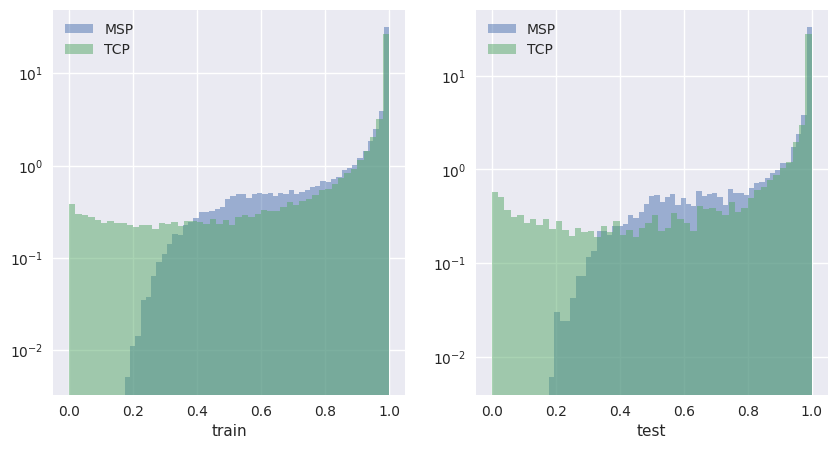

In [8]:
def get_MSP_TCP(dataloader, classifier, device):

    classifier.eval()
    msp = torch.zeros((len(dataloader.dataset)))
    tcp = torch.zeros((len(dataloader.dataset)))
    idx = 0
    for X, y in dataloader:
        batch_size = X.shape[0]

        X = (X / 255)[:, :, 2:30, 2:30]
        y = y.argmax(1)
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            logits = classifier(X)
        msp[idx:idx+batch_size] = get_classifier_MSP(logits)
        tcp[idx:idx+batch_size] = get_classifier_TCP(logits, y)
        idx += batch_size

    return msp, tcp



msp_train, tcp_train = get_MSP_TCP(train_dataloader, classifier, device)
msp_test, tcp_test = get_MSP_TCP(test_dataloader, classifier, device)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_xlabel('train')
ax1.hist(msp_train, alpha=0.5, bins=50, density=True, label='MSP', log=True)
ax1.hist(tcp_train, alpha=0.5, bins=50, density=True, label='TCP', log=True)
ax1.legend()

ax2.set_xlabel('test')
ax2.hist(msp_test, alpha=0.5, bins=50, density=True, label='MSP', log=True)
ax2.hist(tcp_test, alpha=0.5, bins=50, density=True, label='TCP', log=True)
ax2.legend()

# Generator

In [9]:
if G.c_dim == 11:
    n_images = 8

    z = torch.randn((n_images, G.z_dim), device=device)
    if class_selected == 'all':
        labels = torch.randint(0, n_classes, (n_images,), device=device)
    else:
        labels = class_selected * torch.ones((n_images,), dtype=torch.int64, device=device)
    c_labels = F.one_hot(labels, n_classes)
    c_classif = torch.ones((n_images, 1), device=device)
    c = torch.cat((c_labels, c_classif), dim=1)

    ws = G.mapping(z, c, truncation_psi=1)
    img = G.synthesis(ws, noise_mode='const', force_fp32=True)
    img = postprocess_images(img)
    plot_images_grid(img, title='Generated images, confidence=1')
    plt.show()
    print('confidences:', F.softmax(classifier(img), dim=1).max(dim=1).values)

    # change only classif condition
    proba = 0.7
    c_classif = proba * torch.ones((n_images, 1), device=device)
    c = torch.cat((c_labels, c_classif), dim=1)

    ws = G.mapping(z, c, truncation_psi=1)
    img = G.synthesis(ws, noise_mode='const', force_fp32=True)
    img = postprocess_images(img)
    plot_images_grid(img, title=f'Generated images, confidence={proba}')
    plt.show()
    print('confidences:', F.softmax(classifier(img), dim=1).max(dim=1).values)



# MSP direction in S

In [10]:
if G.c_dim == 11:
    n_images = 10000
    confidence_max = 1
    confidence_min = 0.9

    z = torch.randn((n_images, G.z_dim), device=device)
    if class_selected == 'all':
        labels = torch.randint(0, n_classes, (n_images,), device=device)
    else:
        labels = class_selected * torch.ones((n_images,), dtype=torch.int64, device=device)
    c_labels = F.one_hot(labels, n_classes)

    c_classif = confidence_max*torch.ones((n_images, 1), device=device)
    c = torch.cat((c_labels, c_classif), dim=1)
    s_max = torch.empty((n_images, 5632), device=device)
    idx = 0
    for z_i, c_i in zip(DataLoader(z, batch_size=128), DataLoader(c, batch_size=128)):
        batch_size = c_i.shape[0]
        with torch.no_grad():
            ws = G.mapping(z_i, c_i, truncation_psi=1)
            img = G.synthesis(ws, noise_mode='const', force_fp32=True)
        s_vec = styleSpace_dict2vec(styleSpace_values)
        s_max[idx:idx+batch_size] = s_vec
        idx += batch_size
        
        
        
    # WITH NEW Z
    # z = torch.randn((n_images, G.z_dim), device=device)
    # labels = torch.randint(0, n_classes, (n_images,), device=device)
    # c_labels = F.one_hot(labels, n_classes)
    # c_classif = confidence_min*torch.ones((n_images, 1), device=device)
    # c = torch.cat((c_labels, c_classif), dim=1)
    # w_min = G.mapping(z, c, truncation_psi=1)[:,0,:].mean(dim=0)

    # WITHOUT NEW Z
    c_classif = confidence_min*torch.ones((n_images, 1), device=device)
    c = torch.cat((c_labels, c_classif), dim=1)
    s_min = torch.empty((n_images, 5632), device=device)
    idx = 0
    for z_i, c_i in zip(DataLoader(z, batch_size=128), DataLoader(c, batch_size=128)):
        batch_size = c_i.shape[0]
        with torch.no_grad():
            ws = G.mapping(z_i, c_i, truncation_psi=1)
            img = G.synthesis(ws, noise_mode='const', force_fp32=True)
        s_vec = styleSpace_dict2vec(styleSpace_values)
        s_min[idx:idx+batch_size] = s_vec
        idx += batch_size


    s_max = s_max.mean(0)
    s_min = s_min.mean(0)
    s_dir_msp = (s_max - s_min)

In [11]:
if G.c_dim == 11:
    n_images = 8
    lambda_ = 2

    z = torch.randn((n_images, G.z_dim), device=device)
    if class_selected == 'all':
        labels = torch.randint(0, n_classes, (n_images,), device=device)
    else:
        labels = class_selected * torch.ones((n_images,), dtype=torch.int64, device=device)
    c_labels = F.one_hot(labels, n_classes)
    c_classif = torch.ones((n_images, 1), device=device)
    c = torch.cat((c_labels, c_classif), dim=1)

    ws = G.mapping(z, c, truncation_psi=1)
    img = G.synthesis(ws, noise_mode='const', force_fp32=True)
    img = postprocess_images(img)
    s_vec = styleSpace_dict2vec(styleSpace_values)
    plot_images_grid(img, title='Generated images, confidence=1')
    plt.show()
    print('confidences:', F.softmax(classifier(img), dim=1).max(dim=1).values)

    # move along w_dir_msp

    s_vec_moved = s_vec - lambda_ * s_dir_msp
    img = generate_img_from_s(s_vec_moved)
    img = postprocess_images(img)
    plot_images_grid(img, title=f'Generated images, edited along s_dir_msp')
    plt.show()
    print('confidences:', F.softmax(classifier(img), dim=1).max(dim=1).values)

# Generate data

In [12]:
def classify_from_ws(ws, labels=None):
    dataloader = DataLoader(TensorDataset(ws, labels), 128)
    s = torch.empty((ws.shape[0], 5632), device=device)
    msp = torch.empty(ws.shape[0])
    tcp = torch.empty(ws.shape[0])
    idx_batch = 0
    for ws_, y in dataloader:
        batch_size = ws_.shape[0]
        img = G.synthesis(ws_, noise_mode='const')
        img = postprocess_images(img)
        logits = classifier(img)
        s[idx_batch:idx_batch+batch_size] = styleSpace_dict2vec(styleSpace_values)
        msp[idx_batch:idx_batch+batch_size] = get_classifier_MSP(logits).cpu()
        tcp[idx_batch:idx_batch+batch_size] = get_classifier_TCP(logits, y).cpu()
        idx_batch += batch_size
    well_classified = msp == tcp
    return s, msp, tcp, well_classified

In [13]:
# TRAIN
if class_selected == 'all':
    n_images_train = 60000
    labels_train = torch.randint(0, n_classes, (n_images_train,), device=device)
else:
    n_images_train = 60000
    labels_train = class_selected * torch.ones((n_images_train,), dtype=torch.int64, device=device)
z_train = torch.randn((n_images_train, G.z_dim), device=device)
c_labels_train = F.one_hot(labels_train, n_classes)
if G.c_dim == 11:
    c_classif_train = 0.8 + 0.2 * torch.rand((n_images_train, 1), device=device)
    c_train = torch.cat((c_labels_train, c_classif_train), dim=1)
elif G.c_dim == 10:
    c_train = c_labels_train

ws_train = G.mapping(z_train, c_train, truncation_psi=1)
w_train = ws_train[:, 0, :]
s_train, msp_train, tcp_train, well_classified_train = classify_from_ws(ws_train, labels_train)

# VAL
if class_selected == 'all':
    n_images_val = 10000
    labels_val = torch.randint(0, n_classes, (n_images_val,), device=device)
else:
    n_images_val = 10000
    labels_val = class_selected * torch.ones((n_images_val,), dtype=torch.int64, device=device)
z_val = torch.randn((n_images_val, G.z_dim), device=device)
c_labels_val = F.one_hot(labels_val, n_classes)
if G.c_dim == 11:
    c_classif_val = 0.8 + 0.2 * torch.rand((n_images_val, 1), device=device)
    c_val = torch.cat((c_labels_val, c_classif_val), dim=1)
elif G.c_dim == 10:
    c_val = c_labels_val

ws_val = G.mapping(z_val, c_val, truncation_psi=1)
w_val = ws_val[:, 0, :]
s_val, msp_val, tcp_val, well_classified_val = classify_from_ws(ws_val, labels_val)


perfo_direction_w = (((w_train[well_classified_train.logical_not()] - w_train.mean(0)) / w_train.std(0)).mean(0)
                       - ((w_train[well_classified_train] - w_train.mean(0)) / w_train.std(0)).mean(0))

perfo_direction_s = (((s_train[well_classified_train.logical_not()] - s_train.mean(0)) / s_train.std(0)).mean(0)
                       - ((s_train[well_classified_train] - s_train.mean(0)) / s_train.std(0)).mean(0))


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


# t-SNE

Text(0.5, 1.0, 'S - Top 10 dimensions')

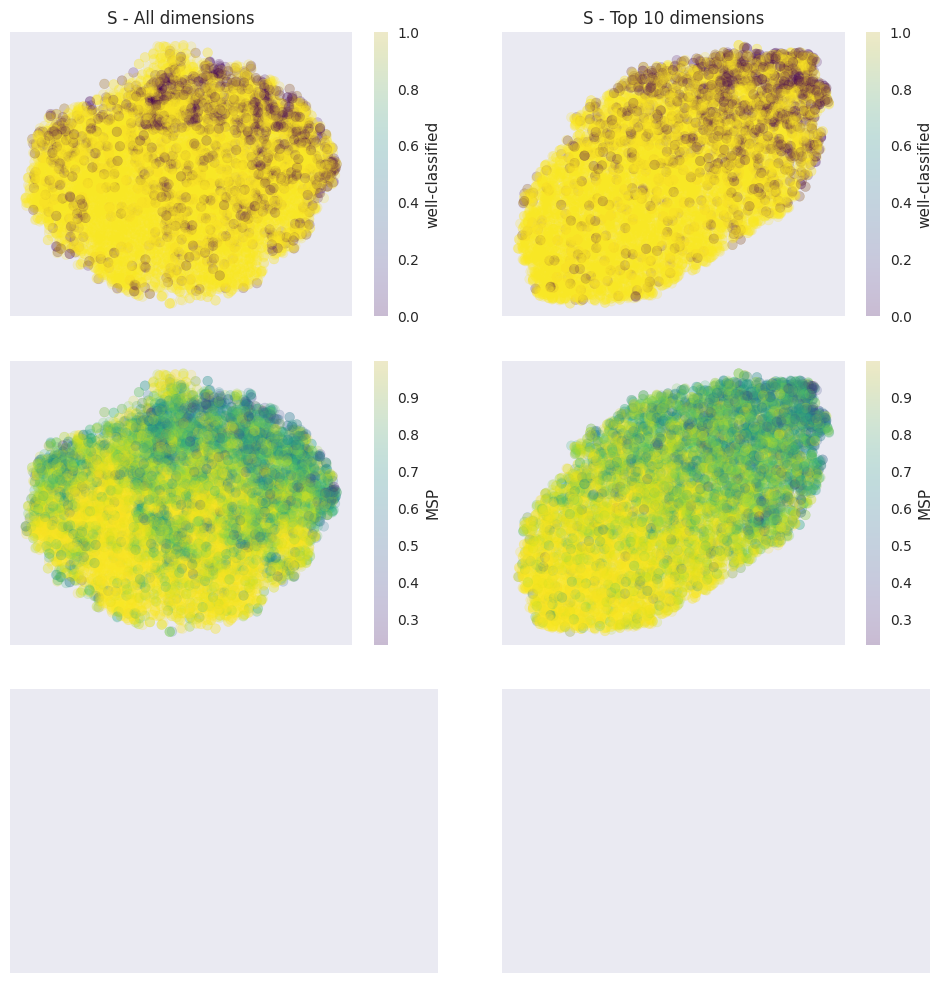

In [14]:
n_samples = 10000

s_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(s_train[:n_samples].cpu().numpy())

top_k = 10
top_k_dims = (-np.abs(perfo_direction_s.cpu())).argsort()[:top_k]
s_embedded_topk = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(s_train[:n_samples, top_k_dims].cpu().numpy())

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i, s_emb in enumerate([s_embedded, s_embedded_topk]):
    sc0 = axs[0, i].scatter(s_emb[:, 0], s_emb[:, 1], c=well_classified_train[:n_samples].cpu(), alpha=0.2, cmap='viridis')
    sc1 = axs[1, i].scatter(s_emb[:, 0], s_emb[:, 1], c=msp_train[:n_samples].cpu(), alpha=0.2, cmap='viridis')
    if G.c_dim == 11:
        sc2 = axs[2, i].scatter(s_emb[:, 0], s_emb[:, 1], c=c_classif_train[:n_samples].cpu(), alpha=0.2, cmap='viridis')
        fig.colorbar(sc2, ax=axs[2, i], label='MSP input')
    fig.colorbar(sc0, ax=axs[0, i], label='well-classified')
    fig.colorbar(sc1, ax=axs[1, i], label='MSP')
fig.tight_layout()
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
axs[0, 0].set_title('S - All dimensions')
axs[0, 1].set_title(f'S - Top {top_k} dimensions')
